In [11]:
from os import system
import os
import pickle
import numpy as np

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.plotBTC as plotBTC

# Test

Run with a variable head gradient to find the one that gives the minimum log-reductions

Results from this are stored in `Dec-21-2022-Review.tar.gz` and are summarized in `results.pkl`

In [12]:
def resetPickle():
    mo.Model.resetListOfModels()
    global caseDict
    with open('caseDict.pkl', 'rb') as f:
        caseDict = pickle.load(f)
    
    pm.Parameter.rebuildListOfObjects(caseDict)
    
    global listOfAllParameters
    listOfAllParameters = pm.Parameter.list_of_vars()
    
def buildSim(caseName):
    ## Create a folder for the case
    currentFolder = "./CASE_{0}".format(caseName)
    currentFile = currentFolder + "/" + caseName +".in"
    system("mkdir " + currentFolder)
    
    ## Initialize PFLOTRAN model
    BoxModel = mo.Model(
        templateFile = templateFile,
        runFile = currentFile,
        execPath = execPath,
        verbose=True
        )
       
    ## Copy template input file to folder
    BoxModel.cloneTemplate()
    
    ## Replace tags for values in case
    for parameter in listOfAllParameters:
        BoxModel.replaceTagInFile(parameter)

    return BoxModel

## Dummy for caseDict
caseDict = {}

def getTemplate(key):
    templateFiles = {"TH_RSandbox_CFT":"tpl_TH_3Dbox_bioparticleCFT_NoH5.in"}

    templateFolder = "."
    return os.path.join(templateFolder, templateFiles[key])

templateFile = getTemplate('TH_RSandbox_CFT')
execPath = "pflotran"

In [13]:
K = 2.488E-02 #10.**-2.
Qin = 0.24 #m/d
f = 10.
H = 10.
r = 40.
C0 = 1.0
decayRate = 3.5353E-06

nu = 0.0000013081 #m²/s
g = 9.81 #m/s²
THETA = 0.35

In [14]:
resetPickle()

In [15]:
caseDict['endTime'].value = 12.

caseDict['BIOPARTICLE']['decayAq'].value = decayRate
caseDict['BIOPARTICLE']['decayIm'].value = decayRate

caseDict['BIOPARTICLE']['katt']['dc'].value = 2.0E-3
caseDict['BIOPARTICLE']['katt']['dp'].value = 1.0E-7
caseDict['BIOPARTICLE']['katt']['Hamaker'].value = 5.0E-21 # J = N·m
caseDict['BIOPARTICLE']['katt']['rhop'].value = 1050.0 # kg/m³ 
caseDict['BIOPARTICLE']['katt']['alpha'].value = 0.01

caseDict['Q']['In'].value  = Qin
caseDict['Q']['Out'].value = -Qin*f
caseDict['k']['X'].value = K*nu/g
caseDict['k']['Y'].value = K*nu/g
caseDict['k']['Z'].value = K*nu/g
caseDict['theta'].value = THETA
caseDict['L']['Z'].value = H
caseDict['inCoord']['X'][1].value = caseDict['outCoord']['X'][1].value + r
caseDict['inCoord']['X'][2].value = caseDict['outCoord']['X'][2].value + r

caseDict['inCoord']['Z'][1].value = 0.0
caseDict['inCoord']['Z'][2].value = H

caseDict['outCoord']['Z'][1].value = 0.0
caseDict['outCoord']['Z'][2].value = H

In [16]:
I_array = np.concatenate([
    np.flip(np.geomspace(-3.2,-4.0, 6)),
    np.linspace(-3, -1.1, 10),
    np.geomspace(-1, -0.6, 4)
    ])

I_array = np.power(10.0, I_array)

In [17]:
for headGradient in I_array:
    caseDict['Gradient']['X'].value  = headGradient
    buildSim("I_1E{:.1f}".format(np.log10(headGradient)))

In [18]:
def runPflotran(pflotranin:str):
    os.system(f"pflotran -pflotranin {pflotranin} > /dev/null")

In [19]:
for m in mo.Model._Model__listObjs:
    print(m.runFile)

./CASE_I_1E-4.0/I_1E-4.0.in
./CASE_I_1E-3.8/I_1E-3.8.in
./CASE_I_1E-3.7/I_1E-3.7.in
./CASE_I_1E-3.5/I_1E-3.5.in
./CASE_I_1E-3.3/I_1E-3.3.in
./CASE_I_1E-3.2/I_1E-3.2.in
./CASE_I_1E-3.0/I_1E-3.0.in
./CASE_I_1E-2.8/I_1E-2.8.in
./CASE_I_1E-2.6/I_1E-2.6.in
./CASE_I_1E-2.4/I_1E-2.4.in
./CASE_I_1E-2.2/I_1E-2.2.in
./CASE_I_1E-1.9/I_1E-1.9.in
./CASE_I_1E-1.7/I_1E-1.7.in
./CASE_I_1E-1.5/I_1E-1.5.in
./CASE_I_1E-1.3/I_1E-1.3.in
./CASE_I_1E-1.1/I_1E-1.1.in
./CASE_I_1E-1.0/I_1E-1.0.in
./CASE_I_1E-0.8/I_1E-0.8.in
./CASE_I_1E-0.7/I_1E-0.7.in
./CASE_I_1E-0.6/I_1E-0.6.in


In [20]:
from multiprocessing import Pool

with Pool() as pool:
    processedBlob = pool.map(
        runPflotran,
        [m.runFile for m in mo.Model._Model__listObjs])

In [21]:
waterDensity = 999.65
m3ToL = 1000.
import os 
from pandas import read_csv

folderToPlot="MASSBALANCES"
os.system("rm -rf MASSBALANCES; mkdir MASSBALANCES")
os.system("cp ./CASE**/*-mas.dat ./MASSBALANCES")

mo.Model.folderFixedToCSV(folderToPlot)     
listOfFiles = os.listdir(folderToPlot)
listOfFiles.sort()
logC_arr = np.zeros(len(listOfFiles))

DONE with  MASSBALANCES/I_1E-0.6-mas.dat
DONE with  MASSBALANCES/I_1E-0.7-mas.dat
DONE with  MASSBALANCES/I_1E-0.8-mas.dat
DONE with  MASSBALANCES/I_1E-1.0-mas.dat
DONE with  MASSBALANCES/I_1E-1.1-mas.dat
DONE with  MASSBALANCES/I_1E-1.3-mas.dat
DONE with  MASSBALANCES/I_1E-1.5-mas.dat
DONE with  MASSBALANCES/I_1E-1.7-mas.dat
DONE with  MASSBALANCES/I_1E-1.9-mas.dat
DONE with  MASSBALANCES/I_1E-2.2-mas.dat
DONE with  MASSBALANCES/I_1E-2.4-mas.dat
DONE with  MASSBALANCES/I_1E-2.6-mas.dat
DONE with  MASSBALANCES/I_1E-2.8-mas.dat
DONE with  MASSBALANCES/I_1E-3.0-mas.dat
DONE with  MASSBALANCES/I_1E-3.2-mas.dat
DONE with  MASSBALANCES/I_1E-3.3-mas.dat
DONE with  MASSBALANCES/I_1E-3.5-mas.dat
DONE with  MASSBALANCES/I_1E-3.7-mas.dat
DONE with  MASSBALANCES/I_1E-3.8-mas.dat
DONE with  MASSBALANCES/I_1E-4.0-mas.dat


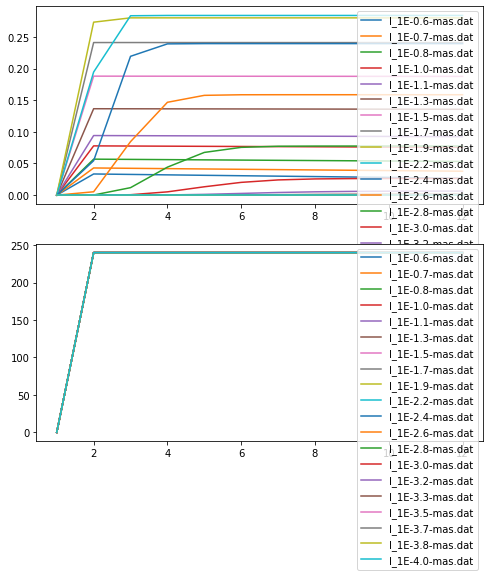

In [22]:
import matplotlib.pyplot as plt
indices = {'t':"Time [d]",\
           'q':"ExtractWell Water Mass [kg/d]",\
           'm':"ExtractWell Vaq [mol/d]"}

normalizeWith={'t':1.0,'q':waterDensity/m3ToL,'m':1.0}

fig, axs = plt.subplots(2,1, figsize=(8,8))
for i,f in enumerate(listOfFiles):
    
    DATA = read_csv(os.path.join(folderToPlot,f), delimiter=",")
    q_water = DATA["ExtractWell Water Mass [kg/d]"].iloc[-1]/normalizeWith['q']
    m_virus = DATA["ExtractWell Vaq [mol/d]"].iloc[-1]/normalizeWith['m']
    
    concentration = np.divide(m_virus, q_water)
    logC_arr[i] = -np.log10(concentration)

    axs[0].plot(DATA["Time [d]"], -DATA["ExtractWell Vaq [mol/d]"], label=f)
    axs[1].plot(DATA["Time [d]"], DATA["InjectWell Vaq [mol/d]"], label=f)
for ax in axs: ax.legend()
plt.show()

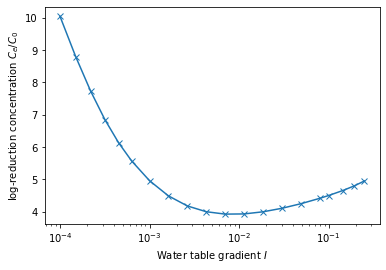

In [25]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(np.flip(I_array), logC_arr, marker="x")
ax.set(xscale='log')
ax.set_xlabel("Water table gradient $I$")
ax.set_ylabel("log-reduction concentration $C_e/C_0$")
plt.show()


In [24]:
with open("results.pkl", 'wb') as f:
    pickle.dump({"I":np.flip(I_array), "C":logC_arr}, f)